In [1]:
import numpy as np
import os
import nibabel as nib
import ants
import brainsss
import matplotlib.pyplot as plt
import psutil
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import time
import scipy
import itertools
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
%matplotlib inline

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly = 'fly_087'
func_path = os.path.join(dataset_path, fly, 'func_0')

In [3]:
def load_functional_data(func_path):
    # this was warped into FDA in the unclean version of this notebook
    load_file = os.path.join(dataset_path, fly, 'func_0','brain_zscored_green_high_pass_masked_warped_fda.npy')
    func_in_fda = np.load(load_file)
    print(func_in_fda.shape)
    return func_in_fda

In [4]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

In [5]:
def get_hemibrain_bounding_box(mask):
    
    start = {}
    stop = {}
    for axis, name in zip([0,1,2],['x','y','z']):
        
        start[name] = np.min(np.where(mask != 0)[axis])
        start[name] = int(np.floor(start[name]))
        
        stop[name] = np.max(np.where(mask != 0)[axis])
        stop[name] = int(np.ceil(stop[name]))
        
    return start, stop

In [6]:
func_in_fda = load_functional_data(func_path)

(241, 112, 36, 3384)


In [66]:
# to add more juice to supervoxel creation let's mirror and double the timeseries data
func_in_fda_midline_flip = func_in_fda[::-1,:,:,:]
time_doubled = np.concatenate((func_in_fda, func_in_fda_midline_flip), axis=3)
time_doubled.shape

(241, 112, 36, 6768)

In [7]:
dim_o = {'x': func_in_fda.shape[0],
         'y': func_in_fda.shape[1],
         'z': func_in_fda.shape[2]}

In [8]:
FDA, FDA_lowres = load_FDA()

In [9]:
hemibrain_mask_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA/synapses_transformed_FDA_0p38um_smoothed_mask.npy'
hemibrain_mask = np.load(hemibrain_mask_file)

In [10]:
hemibrain_mask.shape

(1652, 769, 478)

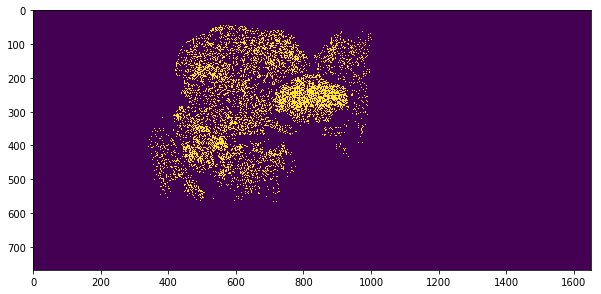

In [407]:
plt.figure(figsize=(10,10))
#plt.imshow(hemibrain_mask[400:600,100:300,300].T>0)
plt.imshow(hemibrain_mask[...,280].T>0)

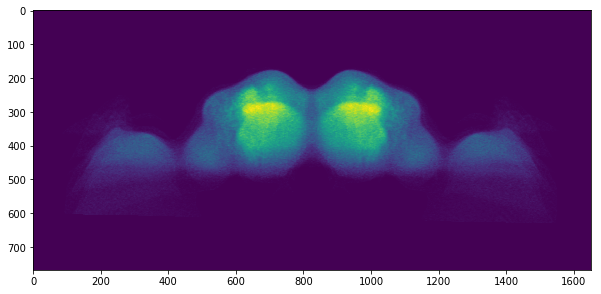

In [25]:
plt.figure(figsize=(10,10))
#plt.imshow(hemibrain_mask[400:600,100:300,300].T>0)
plt.imshow(FDA[...,100].T)

In [10]:
mask_dilated = binary_dilation(hemibrain_mask>0, iterations=6)
hemibrain_mask_filled = binary_erosion(mask_dilated, structure=np.ones((6,6,6)))

In [11]:
hemibrain_mask_filled = ants.from_numpy(hemibrain_mask_filled.astype('float32'))
hemibrain_mask_filled.set_spacing((.38,.38,.38))
hemibrain_mask_filled_lowres = ants.resample_image(hemibrain_mask_filled,(2.6,2.6,5),use_voxels=False,interp_type=0)
hemibrain_mask_filled_lowres = hemibrain_mask_filled_lowres.numpy()>0

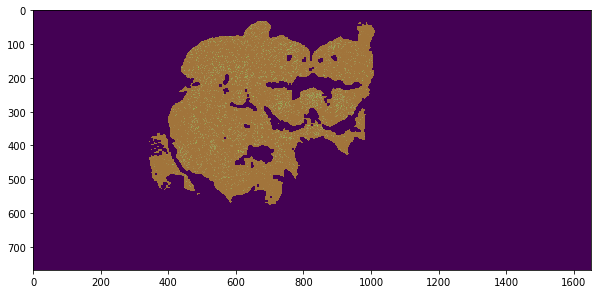

In [578]:
plt.figure(figsize=(10,10))
z=251
plt.imshow(hemibrain_mask_filled[...,z].T)
plt.imshow(hemibrain_mask[...,z].T,alpha=.5)

In [579]:
7/.38

18.42105263157895

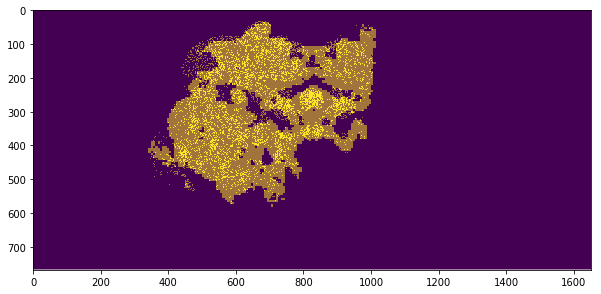

In [577]:
plt.figure(figsize=(10,10))
z=251
plt.imshow(temp[:,:,z].T)
plt.imshow(hemibrain_mask[...,z].T>0,alpha=.5)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (241, 112, 36)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [12]:
temp = ants.from_numpy(hemibrain_mask_filled_lowres.astype('float32'))
temp.set_spacing((2.6,2.6,5))
temp = ants.resample_image(temp,(1652,768,479),use_voxels=True)

In [13]:
start, stop = get_hemibrain_bounding_box(hemibrain_mask_filled_lowres)

In [14]:
hemibrain_mask_filled_lowres_cropped = hemibrain_mask_filled_lowres[start['x']:stop['x'],
                                 start['y']:stop['y'],
                                 start['z']:stop['z']]

In [16]:
FDA_cropped_to_hemi = FDA_lowres[start['x']:stop['x'],
                                 start['y']:stop['y'],
                                 start['z']:stop['z']]

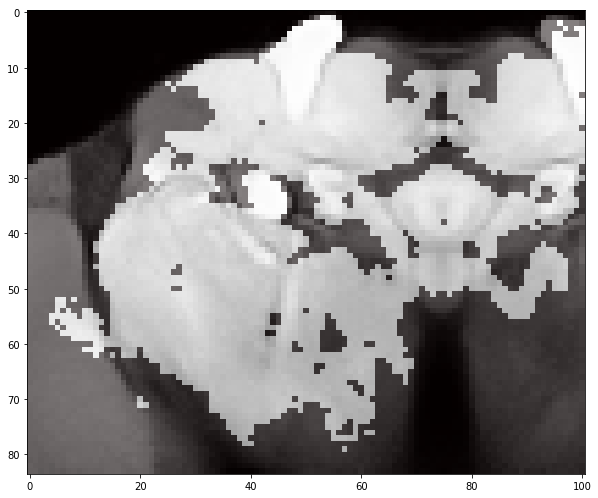

In [547]:
plt.figure(figsize=(10,10))
z=13
plt.imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
plt.imshow(hemibrain_mask_filled_lowres_cropped[:,:,z].T,alpha=.5,cmap='hot')

In [175]:
func_cropped_to_hemi = time_doubled[start['x']:stop['x'],
                                    start['y']:stop['y'],
                                    start['z']:stop['z'],
                                    :]
func_cropped_to_hemi.shape

(101, 84, 29, 6768)

In [18]:
func_cropped_to_hemi = func_in_fda[start['x']:stop['x'],
                                    start['y']:stop['y'],
                                    start['z']:stop['z'],
                                    :]

In [186]:
hemibrain_mask_filled_lowres_cropped.shape

(101, 84, 29)

In [187]:
### MASK FUNC WITH HEMIBRAIN ###
func_cropped_to_hemi_masked = func_cropped_to_hemi * hemibrain_mask_filled_lowres_cropped[:,:,:,np.newaxis]

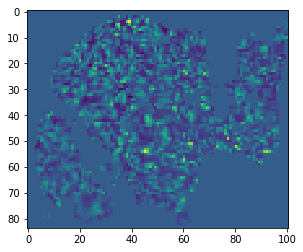

In [189]:
plt.imshow(func_cropped_to_hemi_masked[:,:,20,100].T)

In [19]:
dim_c = {'x': func_cropped_to_hemi.shape[0],
         'y': func_cropped_to_hemi.shape[1],
         'z': func_cropped_to_hemi.shape[2],
         't': func_cropped_to_hemi.shape[3]}

In [191]:
func_2d = np.reshape(func_cropped_to_hemi_masked, (dim_c['x']*dim_c['y']*dim_c['z'],dim_c['t']))
func_2d.shape

(246036, 6768)

In [356]:
clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA"
connectivity = grid_to_graph(dim_c['x'],dim_c['y'],dim_c['z'])
n_clusters = 3000
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)

In [357]:
t0 = time.time()
cluster_model.fit(func_2d)
print('DONE. Duration: {}'.format(time.time()-t0))

DONE. Duration: 13.875463962554932


In [358]:
labels_flat = cluster_model.labels_
print(labels_flat.shape)

(246036,)


In [359]:
save_file = os.path.join(clustering_dir, '20220701_cluster_labels_flat_3000')
np.save(save_file, labels_flat)

In [360]:
labels_3d = np.reshape(labels_flat,(dim_c['x'],dim_c['y'],dim_c['z']))

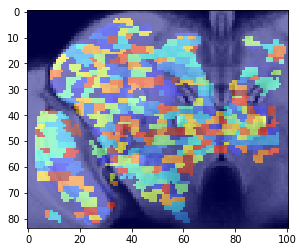

In [394]:
z=21
plt.imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
plt.imshow(labels_3d[:,:,z].T,cmap='jet',alpha=.5)

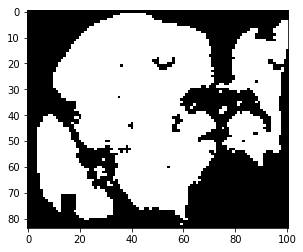

In [385]:
plt.imshow(hemibrain_mask_filled_lowres_cropped[:,:,z].T,cmap='Greys_r')

In [247]:
hemibrain_mask_filled_lowres_cropped.shape, labels_3d.shape

((101, 84, 29), (101, 84, 29))

In [249]:
synapses_1d = hemibrain_mask_filled_lowres_cropped.flatten()

In [254]:
synapses_in_sv

31

In [260]:
labels_flat.shape

(246036,)

In [255]:
synapses = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    synapses_in_sv = np.sum(synapses_1d[cluster_indicies])
    synapses.append(synapses_in_sv)
synapses=np.asarray(synapses)

In [279]:
synapses

array([1821,   76,   37, ...,   14,   25,   31])

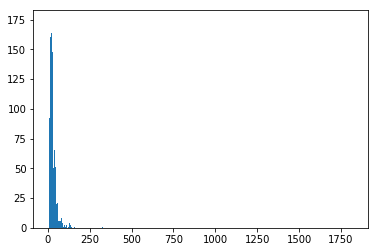

In [276]:
plt.hist(synapses,bins=1000);

In [339]:
np.sort(synapses)[-10:] #

array([ 144,  146,  156,  158,  160,  177,  218,  301,  327, 1821])

In [330]:
np.argsort(synapses)[-10:] #

array([523, 396, 245, 179, 189, 129, 198, 209, 287,   0])

In [375]:
cluster_sizes = []
for cluster in range(n_clusters):
    cluster_sizes.append(len(np.where(labels_flat==cluster)[0]))
background_cluster = np.argmax(cluster_sizes)

In [229]:
cluster_sizes[background_cluster] = 0

In [363]:
np.argsort(cluster_sizes)[-10:]

array([132,  98, 256,  28,  64, 368, 363, 167, 537,   8])

In [344]:
2.6*2.6*5*146

4934.8

In [384]:
np.sort(cluster_sizes)[-10:]

array([   128,    129,    129,    143,    152,    157,    169,    169,
          179, 170201])

(0, 2000)

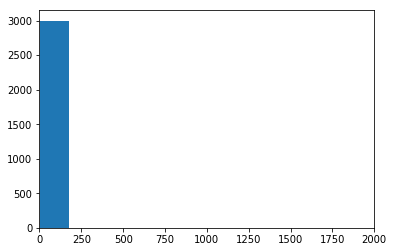

In [381]:
plt.hist(cluster_sizes,bins=1000);
plt.xlim(0,2000)

In [382]:
np.median(cluster_sizes)

22.0

In [383]:
2.6*2.6*5*22

743.6000000000001

In [238]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    mean_signal = np.mean(func_2d[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals=np.asarray(signals)

In [346]:
cluster_signals.shape

(2500, 6768)

In [240]:
cluster_signal_avg = np.mean(np.abs(cluster_signals),axis=1)

In [243]:
np.sum(cluster_signal_avg == 0)

0

In [391]:
colored = np.zeros((dim_c['x']*dim_c['y']*dim_c['z']))
for cluster_num in [0]:
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    colored[cluster_indicies] = 1
colored = np.reshape(colored,(dim_c['x'],dim_c['y'],dim_c['z']))

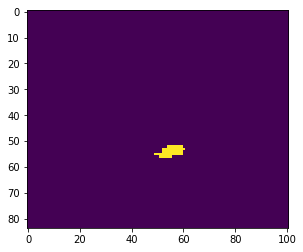

In [392]:
plt.imshow(np.max(colored,axis=2).T)

In [371]:
np.sum(colored,axis=(0,1)).argmax()

19

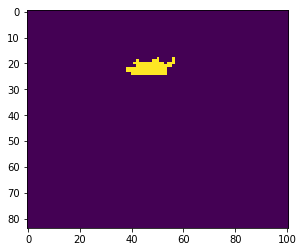

In [372]:
plt.imshow(colored[:,:,19].T)

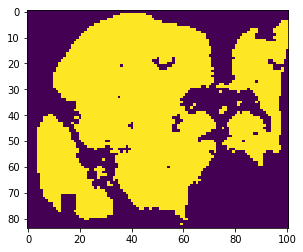

In [301]:
plt.imshow(hemibrain_mask_filled_lowres_cropped[:,:,19].T)

In [487]:
# now we want to warp the supervoxels into FDA space

supervoxels_uncropped = np.zeros((dim_o['x'], dim_o['y'], dim_o['z']))
supervoxels_uncropped[:] = np.nan

supervoxels_uncropped[start['x']:stop['x'],
                      start['y']:stop['y'],
                      start['z']:stop['z']] = labels_3d

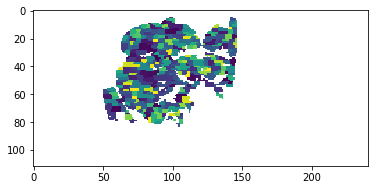

In [488]:
plt.imshow(supervoxels_uncropped[:,:,20].T)

In [489]:
supervoxels_uncropped = ants.from_numpy(supervoxels_uncropped)
supervoxels_uncropped.set_spacing((2.6,2.6,5))
supervoxels_highres = ants.resample_image(supervoxels_uncropped,(1652,768,479),use_voxels=True)

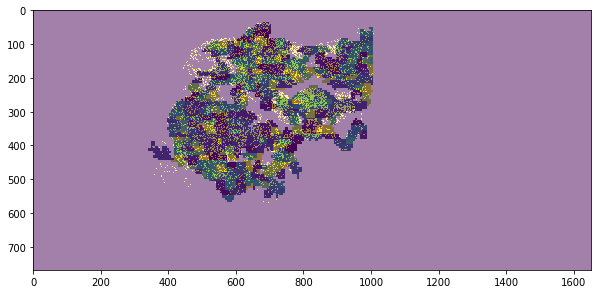

In [525]:
plt.figure(figsize=(10,10))
z=245
plt.imshow(supervoxels_highres[:,:,z].T)
plt.imshow(hemibrain_mask[...,z].T>0,alpha=.5)

In [495]:
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220701_supervoxel_labels_in_fda')
np.save(save_file, supervoxels_highres.numpy())

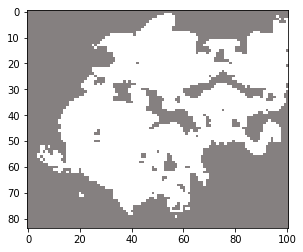

In [543]:
z=13
#plt.imshow(labels_3d[:,:,z].T,alpha=.5,cmap='hot')
plt.imshow(hemibrain_mask_filled_lowres_cropped[:,:,z].T,alpha=.5,cmap='hot')

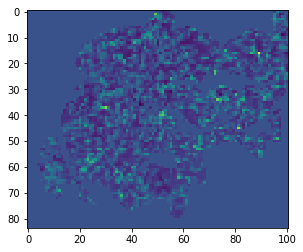

In [535]:
plt.imshow(func_cropped_to_hemi_masked[:,:,z,100].T)

# lets get some behavior corrs to use as well

In [ ]:
func_in_fda_midline_flip = func_in_fda[::-1,:,:,:]
func_cropped_to_hemi_midline_flip = func_in_fda_midline_flip[start['x']:stop['x'],
                                    start['y']:stop['y'],
                                    start['z']:stop['z'],
                                    :]

In [24]:
func_cropped_to_hemi = func_in_fda[start['x']:stop['x'],
                                    start['y']:stop['y'],
                                    start['z']:stop['z'],
                                    :]

In [20]:
func_cropped_to_hemi.shape

(101, 84, 29, 3384)

In [421]:
func_cropped_to_hemi.shape, func_cropped_to_hemi_midline_flip.shape

((101, 84, 29, 3384), (101, 84, 29, 3384))

In [21]:
n_clusters = 3000
clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA"
save_file = os.path.join(clustering_dir, '20220701_cluster_labels_flat_3000.npy')
labels_flat = np.load(save_file)
labels_3d = np.reshape(labels_flat,(dim_c['x'],dim_c['y'],dim_c['z']))

cluster_sizes = []
for cluster in range(n_clusters):
    cluster_sizes.append(len(np.where(labels_flat==cluster)[0]))
background_cluster = np.argmax(cluster_sizes)

labels_3d = labels_3d.astype('float32')
labels_3d[np.where(labels_3d==background_cluster)] = np.nan

#now that we removed background cluster, lets give it to 0 so we can get rid of "0" as well
#ie, what was called 0 is now called the previous background_cluster id number
labels_3d[np.where(labels_3d==0)] = background_cluster
labels_flat = labels_3d.flatten()

In [481]:
save_file = os.path.join(clustering_dir, '20220701_cluster_labels_flat_3000_nobkgrnd')
np.save(save_file, labels_flat)

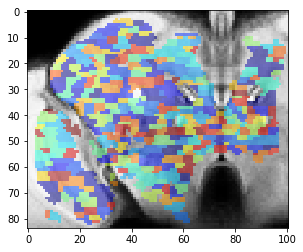

In [401]:
z=21
plt.imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
plt.imshow(labels_3d[:,:,z].T,cmap='jet',alpha=.5)

In [408]:
# if i am going to run correlation in this space i need to know the timing aka z slice of each voxel
# for now lets ignore it

### Load fictrac ###
fps = 50
load_directory = os.path.join(dataset_path, fly, 'func_0')
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000  

### load brain timestamps ###
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [409]:
### interpolate fictrac to match the timestamps of middle slice
z=25
behavior = 'dRotLabY'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

In [423]:
neural_signal_2d_mirror = np.reshape(func_cropped_to_hemi_midline_flip,(dim_c['x']*dim_c['y']*dim_c['z'],int(dim_c['t']/2)))
neural_signal_2d = np.reshape(func_cropped_to_hemi,(dim_c['x']*dim_c['y']*dim_c['z'],int(dim_c['t']/2)))

signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    mean_signal = np.mean(neural_signal_2d[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals=np.asarray(signals)

signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    mean_signal = np.mean(neural_signal_2d_mirror[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals_mirror=np.asarray(signals)

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [23]:
neural_signal_2d = np.reshape(func_cropped_to_hemi,(dim_c['x']*dim_c['y']*dim_c['z'],dim_c['t']))
neural_signal_2d.shape

(246036, 3384)

In [33]:
cluster_indicies

array([153891, 156298, 156326, 156327, 158734, 158762, 158763, 158791,
       161170, 161198, 161199, 161227, 163606, 163634, 163663, 166070,
       166099])

In [39]:
random.shuffle(cluster_indicies)
half = int(len(cluster_indicies)/2)
print(cluster_indicies[half:])
print(cluster_indicies[:half])

[158762 166099 161227 156298 156326 158763 163606 166070 153891]
[158734 156327 161170 161198 163634 163663 158791 161199]


In [28]:
signals = np.empty(n_clusters)
signals.shape

(3000,)

In [32]:
signals = np.zeros((n_clusters,100,3384))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    
    for i in range(100):
        random.shuffle(cluster_indicies)
        half = int(len(cluster_indicies)/2)
        ind = cluster_indicies[half:]
        mean_signal = np.mean(neural_signal_2d[ind,:], axis=0)
        signals[cluster_num,i,:] = mean_signal

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [33]:
signals.shape

(3000, 100, 3384)

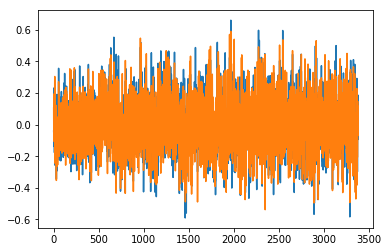

In [34]:
plt.plot(signals[100,0,:])
plt.plot(signals[100,1,:])


In [35]:
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220711_cluster_signals_resampled')
np.save(save_file, signals)

In [24]:
signals_1 = []
signals_2 = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(labels_flat==cluster_num)[0]
    random.shuffle(cluster_indicies)
    half = int(len(cluster_indicies)/2)

    c_ind1 = cluster_indicies[half:]
    mean_signal = np.mean(neural_signal_2d[c_ind1,:], axis=0)
    signals_1.append(mean_signal)
    
    c_ind2 = cluster_indicies[:half]
    mean_signal = np.mean(neural_signal_2d[c_ind2,:], axis=0)
    signals_2.append(mean_signal)
cluster_signals_1=np.asarray(signals_1)
cluster_signals_2=np.asarray(signals_2)

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


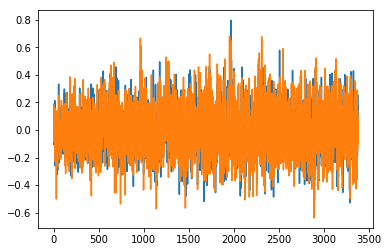

In [25]:
plt.plot(cluster_signals_1[100,:])
plt.plot(cluster_signals_2[100,:])

In [48]:
split_corrs = []
for i in range(3000):
    split_corrs.append(scipy.stats.pearsonr(cluster_signals_1[i,:], cluster_signals_2[i,:])[0])


/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  6.,  20.,  64., 212., 472., 748., 825., 485., 150.,  17.]),
 array([0.17868699, 0.2571207 , 0.33555442, 0.41398814, 0.49242187,
        0.5708556 , 0.6492893 , 0.72772306, 0.80615675, 0.8845905 ,
        0.9630242 ], dtype=float32),
 <a list of 10 Patch objects>)

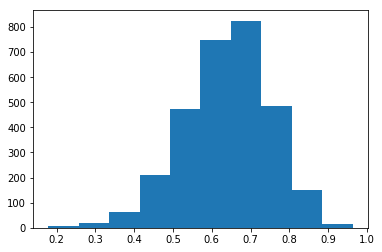

In [49]:
plt.hist(split_corrs)

In [44]:
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220707_cluster_signals_half_2')
np.save(save_file, cluster_signals_2)

In [45]:
cluster_signals_1[0,:]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [ ]:
cluster_signals_mirror.shape

In [486]:
save_file = os.path.join(clustering_dir, '20220701_cluster_signals_mirror')
np.save(save_file, cluster_signals_mirror)

In [465]:
###########
### FWD ###
###########

z=25
behavior = 'dRotLabY'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

cluster_corrs = []
for cluster in range(n_clusters):
    cluster_corrs.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals[cluster,:])[0])
cluster_corrs = np.asarray(cluster_corrs)

cluster_corrs_mirror = []
for cluster in range(n_clusters):
    cluster_corrs_mirror.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals_mirror[cluster,:])[0])
cluster_corrs_mirror = np.asarray(cluster_corrs_mirror)

corrs = (cluster_corrs + cluster_corrs_mirror)/2

save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220701_fwd_corrs')
np.save(save_file, corrs)

In [464]:
############
### IPSI ###
############

z=25
behavior = 'dRotLabZpos'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

cluster_corrs = []
for cluster in range(n_clusters):
    cluster_corrs.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals[cluster,:])[0])
cluster_corrs = np.asarray(cluster_corrs)

behavior = 'dRotLabZneg'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

cluster_corrs_mirror = []
for cluster in range(n_clusters):
    cluster_corrs_mirror.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals_mirror[cluster,:])[0])
cluster_corrs_mirror = np.asarray(cluster_corrs_mirror)

corrs = (cluster_corrs + cluster_corrs_mirror)/2

save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220701_ipsi_corrs')
np.save(save_file, corrs)

In [466]:
##############
### CONTRA ###
##############

z=25
behavior = 'dRotLabZpos'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

cluster_corrs = []
for cluster in range(n_clusters):
    cluster_corrs.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals_mirror[cluster,:])[0])
cluster_corrs = np.asarray(cluster_corrs)

behavior = 'dRotLabZneg'
fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)

cluster_corrs_mirror = []
for cluster in range(n_clusters):
    cluster_corrs_mirror.append(scipy.stats.pearsonr(fictrac_interp, cluster_signals[cluster,:])[0])
cluster_corrs_mirror = np.asarray(cluster_corrs_mirror)

corrs = (cluster_corrs + cluster_corrs_mirror)/2

save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'
save_file = os.path.join(save_dir, '20220701_contra_corrs')
np.save(save_file, corrs)

In [446]:
def clusters_to_3d(neural_signals):
    colored = np.zeros((dim_c['x']*dim_c['y']*dim_c['z']))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels_flat==cluster_num)[0]
        colored[cluster_indicies] = neural_signals[cluster_num]
    colored = np.reshape(colored,(dim_c['x'],dim_c['y'],dim_c['z']))
    return colored

In [467]:
### load fresh
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'

save_file = os.path.join(save_dir, '20220701_ipsi_corrs.npy')
ipsi_turn_corrs = np.load(save_file)

save_file = os.path.join(save_dir, '20220701_contra_corrs.npy')
contra_turn_corrs = np.load(save_file)

save_file = os.path.join(save_dir, '20220701_fwd_corrs.npy')
fwd_corrs = np.load(save_file)

In [468]:
contra_turn_corrs.shape

(3000,)

In [478]:
colored_contra = clusters_to_3d(contra_turn_corrs)
colored_ipsi = clusters_to_3d(ipsi_turn_corrs)
colored_fwd = clusters_to_3d(fwd_corrs)

In [479]:
### 3d

threshold = .17

colored_contra[np.where(colored_contra<threshold)] = 0
colored_contra[np.where(colored_contra>threshold)] = 1

colored_ipsi[np.where(colored_ipsi<threshold)] = 0
colored_ipsi[np.where(colored_ipsi>threshold)] = 1

colored_fwd[np.where(colored_fwd<threshold)] = 0
colored_fwd[np.where(colored_fwd>threshold)] = 1

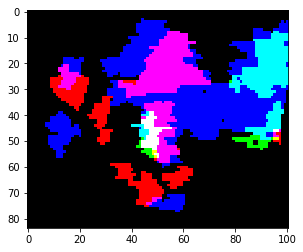

In [480]:
rgb = np.concatenate((colored_ipsi[...,np.newaxis], colored_contra[...,np.newaxis], colored_fwd[...,np.newaxis]),axis=3)

rgb = np.swapaxes(rgb,0,1)

rgb_maxproj = np.max(rgb,axis=2)

plt.imshow(rgb_maxproj)